In [1]:

import numpy as np
import torch
import matplotlib.pyplot as plt

from sgnNet import SGN
from refit_dataloader import load_house_csv
from inference import infer_seq2point_timeline_all_with_hard, smape


In [2]:
DATAPATH = r"C:\\Users\\rcper\SGN_NILM\\refit_data\\CLEAN_House3.csv"
APPLIANCE_COL = "Appliance6"
MAX_ROWS = 200000
RESAMPLE_RULE = "30s"
T_ON = 0.85
T_OFF = 0.5
MIN_HOLD = 5

CKPT_PATH = r"models\sgn_best_74.pt"

In [3]:
mains, target, ts = load_house_csv(
    DATAPATH, appliance_col=APPLIANCE_COL, max_rows=MAX_ROWS, resample_rule=RESAMPLE_RULE
)
print(f"Loaded {len(mains)} samples for House6 / {APPLIANCE_COL}")

Loaded 200000 samples for House6 / Appliance6


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(CKPT_PATH, map_location=device)
model = SGN(in_ch=1, hid=64, kind="tcn", out_len=1).to(device)
model.load_state_dict(ckpt["model"])
stats = ckpt["stats"]

# Get gate temperature (use from stats if you saved it; else default)
gate_tau = stats.get("gate_tau", 0.75) if isinstance(stats, dict) else 0.75



C:\Users\rcper\AppData\Local\Temp\ipykernel_10456\4117273088.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location=device)


In [ ]:
power_soft_w, reg_w, prob, gate_hard, power_hard_w = infer_seq2point_timeline_all_with_hard(
    model, mains, stats, device,
    gate_tau=gate_tau,
    t_on=T_ON, t_off=T_OFF, min_hold=MIN_HOLD,
    gate_floor=0.0
)

y_true = target

In [ ]:
# -----------------------------
# Metrics
# -----------------------------


mae_soft = float(np.mean(np.abs(power_soft_w - y_true)))
mae_hard = float(np.mean(np.abs(power_hard_w - y_true)))

energy_true = float(y_true.sum())
sae_soft = float(abs(power_soft_w.sum() - energy_true) / (energy_true + 1e-6))
sae_hard = float(abs(power_hard_w.sum() - energy_true) / (energy_true + 1e-6))

print(f"[TEST][SOFT] MAE (W): {mae_soft:.2f} | SAE: {sae_soft:.4f} | sMAPE: {smape(y_true, power_soft_w):.2f}%")
print(f"[TEST][HARD] MAE (W): {mae_hard:.2f} | SAE: {sae_hard:.4f} | sMAPE: {smape(y_true, power_hard_w):.2f}%")


[TEST][SOFT] MAE (W): 79.31 | SAE: 0.2400 | sMAPE: 93.85%
[TEST][HARD] MAE (W): 77.95 | SAE: 0.0851 | sMAPE: 44.42%


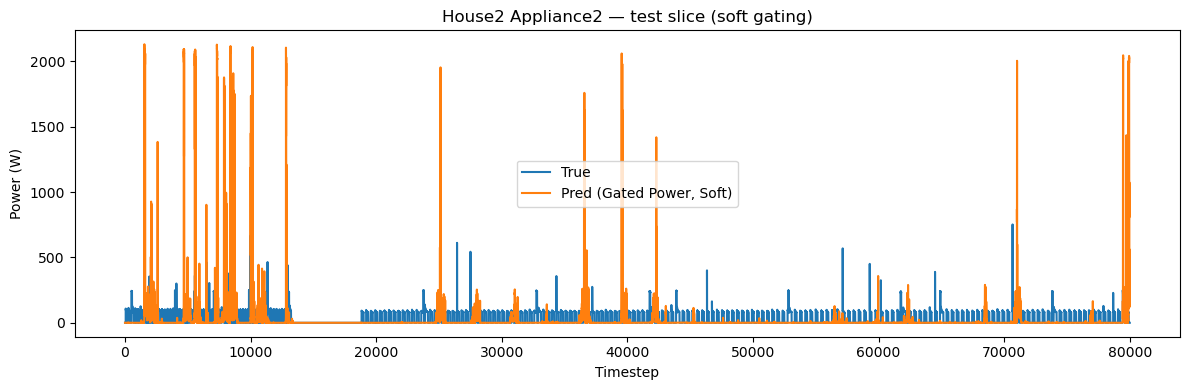

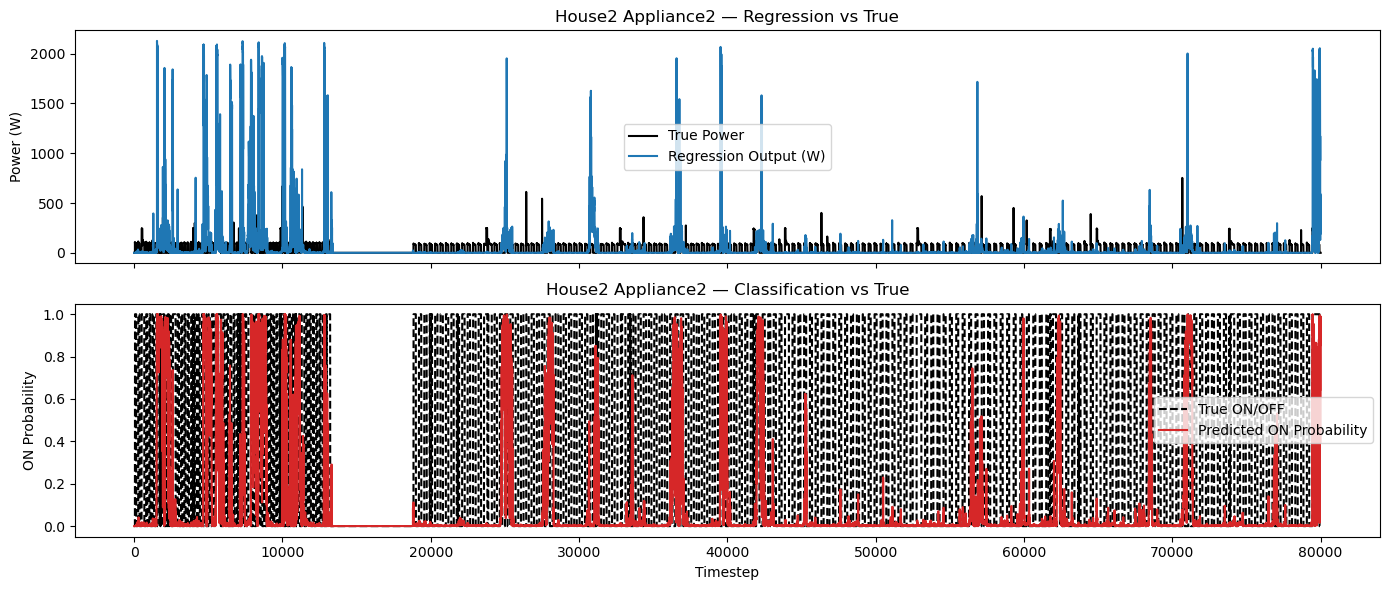

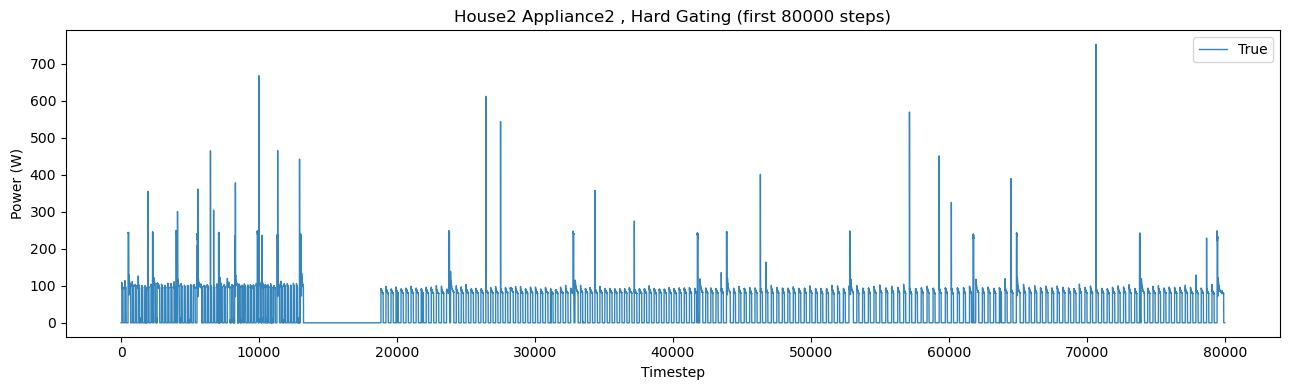

<Figure size 640x480 with 0 Axes>

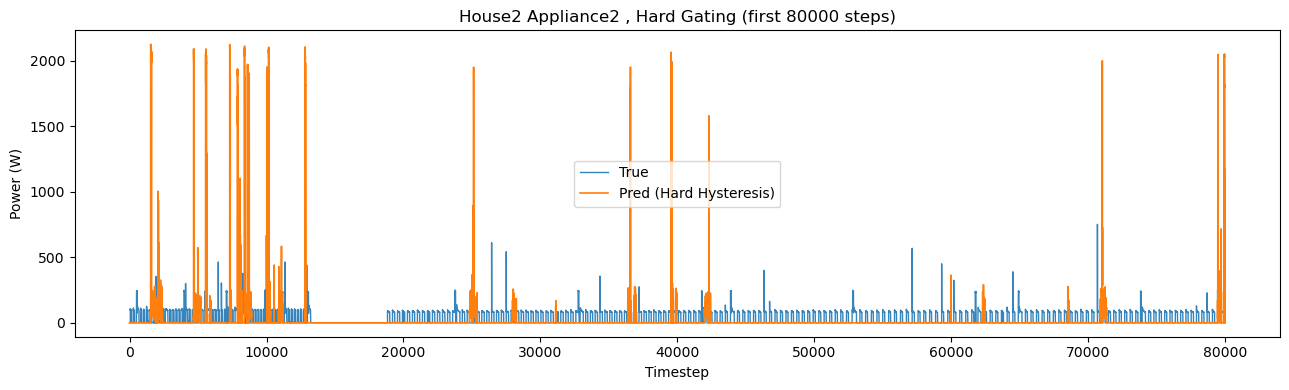

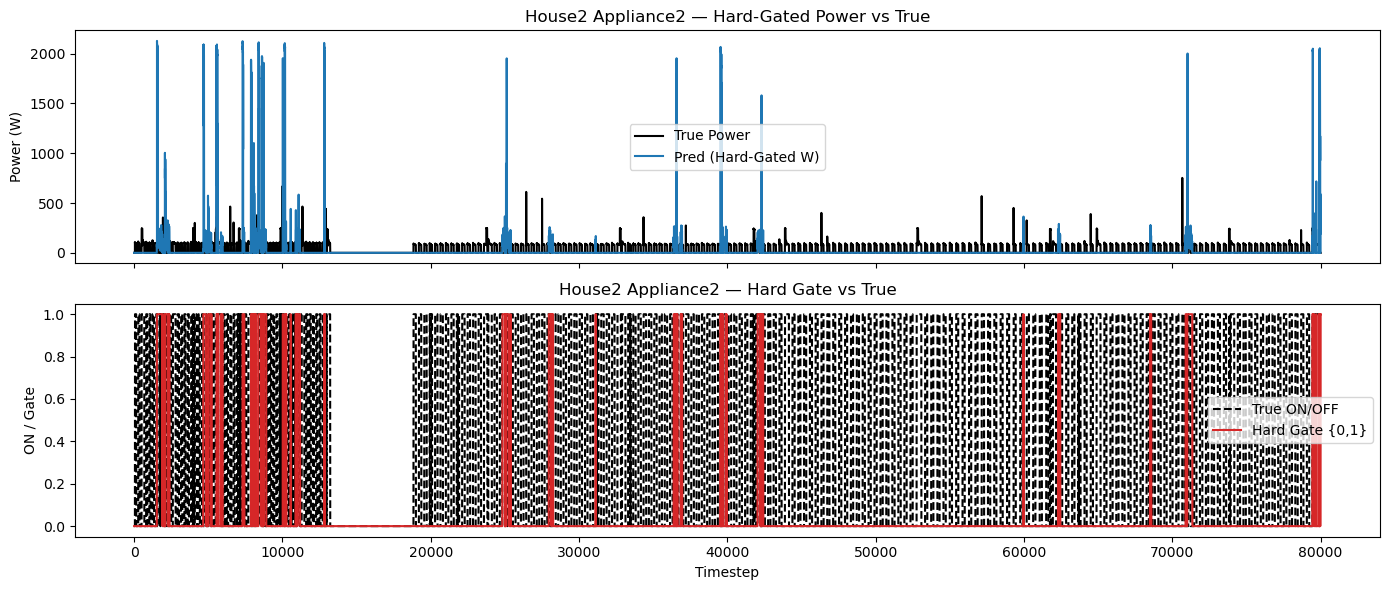

In [ ]:

def smape(a, f):
    denom = (np.abs(a) + np.abs(f)).clip(1e-6, None)
    return (100.0 / len(a)) * np.sum(np.abs(f - a) / denom)

N = min(80000, len(y_true))

plt.figure(figsize=(12,4))
plt.plot(y_true[:N], label="True")
plt.plot(power_soft_w[:N], label="Pred (Gated Power, Soft)")
plt.legend()
plt.title(f"House2 {APPLIANCE_COL} — test slice (soft gating)")
plt.xlabel("Timestep"); plt.ylabel("Power (W)")
plt.tight_layout(); plt.show()

on_threshold = 15.0
true_cls = (y_true[:N] > on_threshold).astype(float)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

ax1.plot(y_true[:N], label="True Power", color="black")
ax1.plot(reg_w[:N], label="Regression Output (W)", color="tab:blue")
ax1.set_ylabel("Power (W)")
ax1.set_title(f"House2 {APPLIANCE_COL} — Regression vs True")
ax1.legend()

ax2.plot(true_cls, label="True ON/OFF", color="black", linestyle="--")
ax2.plot(prob[:N], label="Predicted ON Probability", color="tab:red")
ax2.set_ylabel("ON Probability")
ax2.set_xlabel("Timestep")
ax2.set_ylim(-0.05, 1.05)
ax2.set_title(f"House2 {APPLIANCE_COL} — Classification vs True")
ax2.legend()



plt.tight_layout(); plt.show()
plt.figure(figsize=(13,4))
plt.plot(y_true[:N], label="True", linewidth=1.0, alpha=0.9)
plt.legend()
plt.title(f"House2 {APPLIANCE_COL} , Hard Gating (first {N} steps)")
plt.xlabel("Timestep"); plt.ylabel("Power (W)")
plt.tight_layout(); plt.show()



plt.tight_layout(); plt.show()
plt.figure(figsize=(13,4))
plt.plot(y_true[:N], label="True", linewidth=1.0, alpha=0.9)
plt.plot(power_hard_w[:N], label="Pred (Hard Hysteresis)", linewidth=1.2)
plt.legend()
plt.title(f"House2 {APPLIANCE_COL} , Hard Gating (first {N} steps)")
plt.xlabel("Timestep"); plt.ylabel("Power (W)")
plt.tight_layout(); plt.show()



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# --- Top: True vs Hard-gated power ---
ax1.plot(y_true[:N],            label="True Power",            color="black")
ax1.plot(power_hard_w[:N],      label="Pred (Hard-Gated W)",   color="tab:blue")

ax1.set_ylabel("Power (W)")
ax1.set_title(f"House2 {APPLIANCE_COL} — Hard-Gated Power vs True")
ax1.legend()


ax2.plot(true_cls[:N],          label="True ON/OFF",           color="black", linestyle="--")
ax2.plot(gate_hard[:N],         label="Hard Gate {0,1}",       color="tab:red")
ax2.set_ylabel("ON / Gate")
ax2.set_xlabel("Timestep")
ax2.set_ylim(-0.05, 1.05)
ax2.set_title(f"House2 {APPLIANCE_COL} — Hard Gate vs True")
ax2.legend()

plt.tight_layout(); plt.show()
